# Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning, and more specifically about dimensionality reduction using the PCA and ICA algorithms. You will first work on toy examples, and then apply the methods on a real face dataset.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`).

First let's load the functions we will use

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm


import math

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scipy.io import loadmat

# I - Toy examples
## I - 1) Dataset generation

As mentionned, you will first work on toy datasets. The next three functions are used to generate the data and plot the results.

In [ ]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1:
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')

    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')


    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')


    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T

        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)

    N0=np.sum(y==0)
    N1=np.sum(y==1)

    fig=plt.figure(figsize=(17, 6))

    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()

    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')

    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')

    plt.show()


def frontiere(model, X, y, step=50):

    labels = np.unique(y)

    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)

    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')

    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')

    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])


Now,let's create the data we will use.
Try the 4 different scenarios by simply varying the `scenarioIndex` value between 1 and 4.

**Question** : what do each scenario corresponds to?

## Scenarios generation:

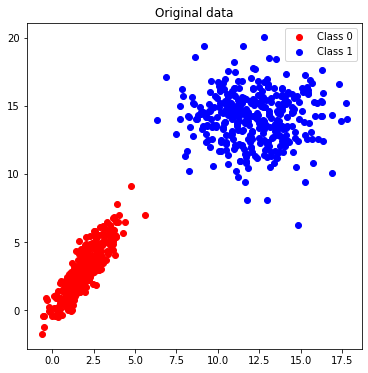

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 1
##

X0_1,X1_1,y_1 = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X_1=np.concatenate((X0_1,X1_1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0_1[:,0],X0_1[:,1],c='r', label='Class 0')
plt.scatter(X1_1[:,0],X1_1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

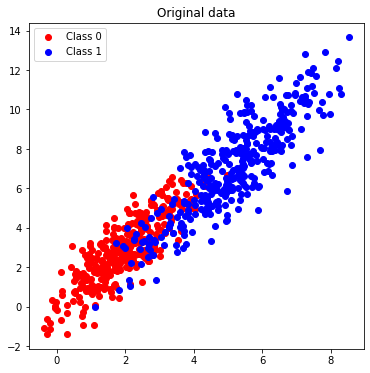

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 2
##

X0_2,X1_2,y_2 = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X_2=np.concatenate((X0_2,X1_2),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0_2[:,0],X0_2[:,1],c='r', label='Class 0')
plt.scatter(X1_2[:,0],X1_2[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

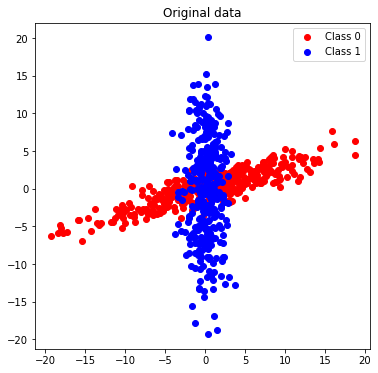

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 3
##

X0_3,X1_3,y_3 = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X_3=np.concatenate((X0_3,X1_3),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0_3[:,0],X0_3[:,1],c='r', label='Class 0')
plt.scatter(X1_3[:,0],X1_3[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

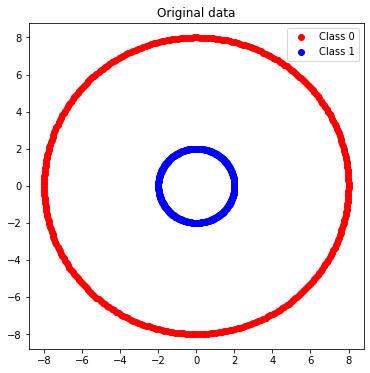

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 4
##

X0_4,X1_4,y_4 = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X_4=np.concatenate((X0_4,X1_4),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0_4[:,0],X0_4[:,1],c='r', label='Class 0')
plt.scatter(X1_4[:,0],X1_4[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

## I - 2) PCA

**BASIC PCA**

It's time to start using the methods seen in class. Let's start with PCA.


As you can see, we have generated two populations (class 0 and class 1). We concatenate them as a single matrix *X* which will be the input for all methods. In this way, the methods will be unaware of the class of the observations (unsupervised) and we will test whether the methods are appropriate for the analysed scenario and if they are able to use less dimensions to correctly distinguish the two classes.


**Question:**
1. Use PCA with the different 4 scenarios and comment the results. When does PCA work well ? Why ? Expain.

PCA part of the assumption that the data is generated by a linear combination of the original variables. If the data is linearly separable, PCA will be able to separate it into different clusters or classes. Additionally, PCA assumes that the noise in the data is normally distributed, which is often a reasonable assumption for many real-world datasets.

It is possible to verify this principle looking to the first and fourth scenarios. In the first scenario the data is linear distributed without superposition of the samples. In this case, PCA can perfectly cluster the data. However, in the fourth case the data is not linearly distributed and the algorithm fails in the clustering task.

In addition, PCA works better when the variables are highly correlated. It means that the variables are high linearly related with each other. In the second and third cases the data is low correlated and PCA does not performs well.


The variance explained by the two first modes is respectively:  [0.96255269 0.03744731]


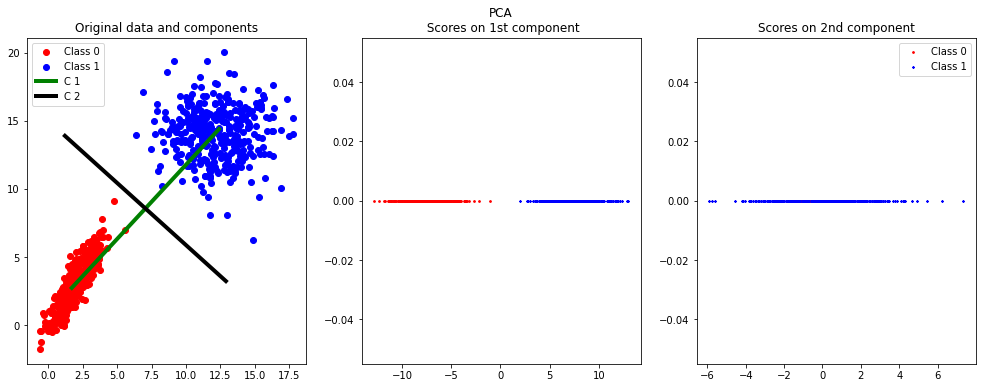

In [ ]:
## PCA
pca_1 = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca_1=pca_1.fit_transform(X_1)
U_1=pca_1.components_.T # we want PC on columns
D_1 = (pca_1.singular_values_)**2/(X_1.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca_1.explained_variance_ratio_)
plotResults(X0_1,X1_1,y_1,U_1,Ypca_1,const=1,title='PCA')

The variance explained by the two first modes is respectively:  [0.97066812 0.02933188]


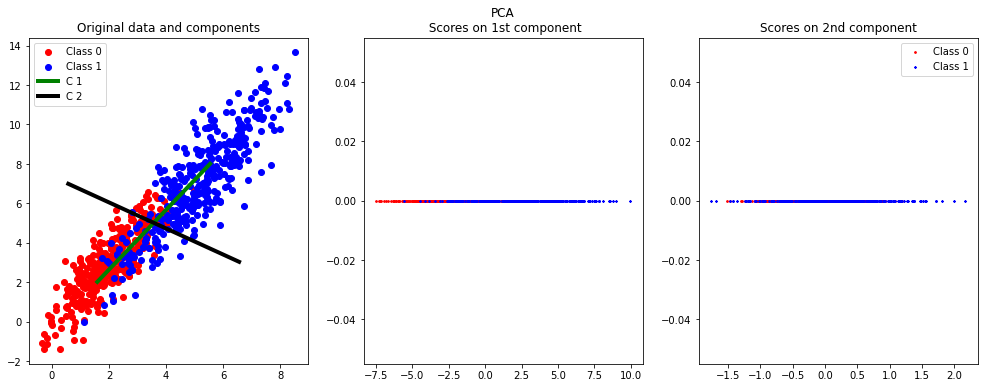

In [ ]:
## PCA
pca_2 = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca_2=pca_2.fit_transform(X_2)
U_2=pca_2.components_.T # we want PC on columns
D_2 = (pca_2.singular_values_)**2/(X_2.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca_2.explained_variance_ratio_)
plotResults(X0_2,X1_2,y_2,U_2,Ypca_2,const=1,title='PCA')

The variance explained by the two first modes is respectively:  [0.64185994 0.35814006]


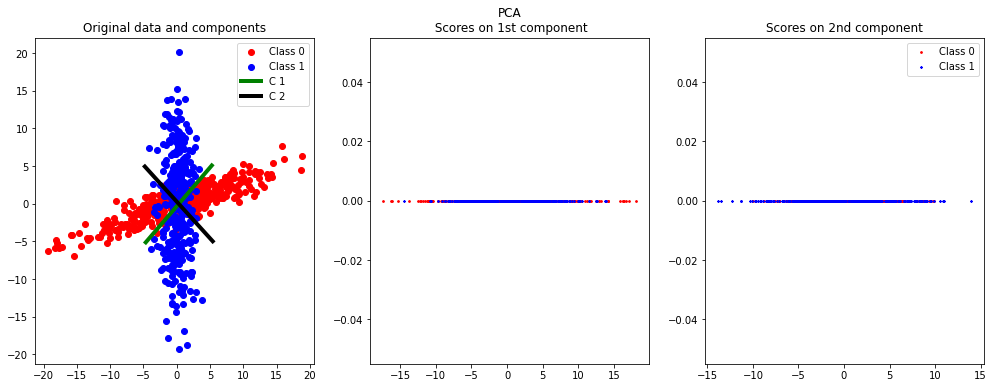

In [ ]:
## PCA
pca_3 = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca_3=pca_3.fit_transform(X_3)
U_3=pca_3.components_.T # we want PC on columns
D_3 = (pca_3.singular_values_)**2/(X_3.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca_3.explained_variance_ratio_)
plotResults(X0_3,X1_3,y_3,U_3,Ypca_3,const=1,title='PCA')

The variance explained by the two first modes is respectively:  [0.50142558 0.49857442]


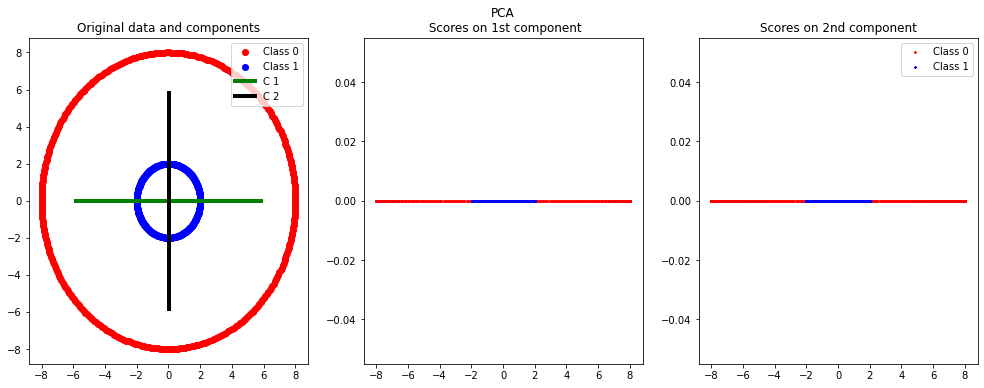

In [ ]:
## PCA
pca_4 = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca_4=pca_4.fit_transform(X_4)
U_4=pca_4.components_.T # we want PC on columns
D_4 = (pca_4.singular_values_)**2/(X_4.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca_4.explained_variance_ratio_)
plotResults(X0_4,X1_4,y_4,U_4,Ypca_4,const=1,title='PCA')

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

In [ ]:
def pcaLecture(X):
    '''
    Inputs:
            X: is a [Nxd] matrix. Every row is an observation and every
              column consists of features.
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the
            coordinates of X onto the new basis given by the eigenvactors U
            of the covariance matrix of X. Columns are the principal components.

            U: columns are Eigenvectors (sorted from the greatest to the lowest eigenvalue)

            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)

            var_explained: percentage of the original variability explained
            by each principal component.
    '''

    N = X.shape[0]
    Xc = X - np.mean(X, axis=0)

    D2, Uh = LA.svd(Xc)[1:3]

    U = Uh.T
    Y = X @ U
    D = D2**2/(N-1)

    tot = np.sum(D)
    var_explained = []

    for d in D:
      var_explained.append(d/np.sum(D))

    return Y,U,D,var_explained


**Question:**
1. Test your own implementation and check whether the results are the same of the scikit-learn implementation

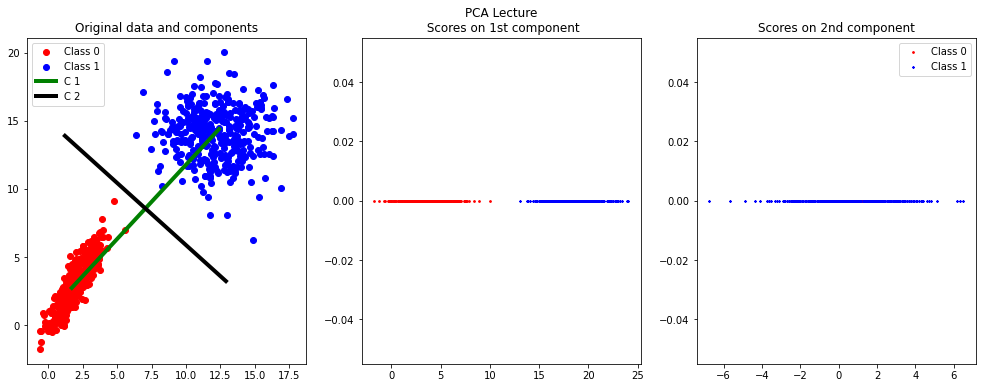

In [ ]:
YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X_1)
plotResults(X0_1,X1_1,y_1,UpcaLec,YpcaLec,const=1,title='PCA Lecture')


**KERNEL PCA**

Let's now use Kernel-PCA with the rbf kernel (you can also test other kernels if you want).

**Question:**
1. What is the interest of kernel PCA over the basic PCA?
2. Use Kernel-PCA with the different 4 scenarios and comment the results. When does K-PCA work well ? Why ?

1. Kernel PCA is applied when the data is non-linearly separable, allowing the detection of non-linear patterns in the data and dimensionality reduction in non-linear spaces.

  Overall, the interest of kernel PCA over basic PCA lies in its ability to detect non-linear patterns in the data and reduce the dimensionality of the data while preserving the non-linear relationships between data points.

2. K-PCA works well when the data has a nonlinear structure. On the other hand it performs badly when the data is highly unbalanced, e.g. one class having significantly more samples than the other. In this case,  K-PCA may not be able to effectively capture the non-linear relationships between the features. In addition, K-PCA is very sensitive to noise.


In [ ]:
# Kernel-PCA
gamma=2
Kpca_1 = KernelPCA(kernel='linear', gamma=gamma, random_state=1)
YKpca_1=Kpca_1.fit_transform(X_1)
DKpca_1=Kpca_1.lambdas_
AKpca_1=Kpca_1.alphas_

plotResults(X0=X0_1,X1=X1_1,y=y_1,Y=YKpca_1,const=1,title='KPCA')

AttributeError: ignored

In [ ]:
# Kernel-PCA
gamma=2
Kpca_2 = KernelPCA(kernel='cosine', gamma=gamma, random_state=1)
YKpca_2=Kpca_2.fit_transform(X_2)
DKpca_2=Kpca_2.lambdas_
AKpca_2=Kpca_2.alphas_

plotResults(X0=X0_2,X1=X1_2,y=y_2,Y=YKpca_2,const=1,title='KPCA')

In [ ]:
# Kernel-PCA
gamma=2
Kpca_3 = KernelPCA(kernel='poly', gamma=gamma, random_state=1)
YKpca_3=Kpca_3.fit_transform(X_3)
DKpca_3=Kpca_3.lambdas_
AKpca_3=Kpca_3.alphas_

plotResults(X0=X0_3,X1=X1_3,y=y_3,Y=YKpca_3,const=1,title='KPCA')

In [ ]:
# Kernel-PCA
gamma=1
Kpca_4 = KernelPCA(kernel='poly', gamma=gamma, random_state=1)
YKpca_4=Kpca_4.fit_transform(X_4)
DKpca_4=Kpca_4.lambdas_
AKpca_4=Kpca_4.alphas_

plotResults(X0=X0_4,X1=X1_4,y=y_4,Y=YKpca_4,const=1,title='KPCA')

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

In [ ]:
def KpcaGaussianLecture(X,gamma):
    '''
    Inputs:
            X: is a [Nxd] matrix. Every row is an observation and every
            column is a feature.

    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the
            coordinates of \phi(X) onto the new basis given by the eigenvactors
            of the covariance matrix of \phi(X). Columns are the principal components.

            An: columns are Eigenvectors normalised (sorted from the greatest
            to the lowest eigenvalue)

            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)

            var_explained: percentage of the original variability explained
            by each principal component.

    '''

    # kernel matrix using a rbf kernel
    def kernel_matrix(X,gamma):
      N=X.shape[0]
      InnerX = np.dot(X,X.T)
      temp1=np.sum(X**2,axis=1).reshape((N,1))
      temp2=np.sum(X**2,axis=1).reshape((1,N))
      Norm1 = np.repeat(temp1,N,axis=1)
      Norm2 = np.repeat(temp2,N,axis=0)
      Norm = Norm1+Norm2-2*InnerX;
      Norm[Norm<1e-10]=0;
      K=np.exp(-Norm/(2*gamma**2))
      return K

    N=X.shape[0]

    K=kernel_matrix(X,gamma)

    # center kernel matrix
    oneN=np.ones((N,N))/N;
    Kc= K - oneN @ K - K @ oneN + (oneN @ K) @ oneN

    # eigenvalue analysis
    D,A=LA.eigh(Kc)
    idx = D.argsort()[::-1]  # reverse order to make 'descend'
    D = np.real(D[idx])
    D[D<0]=1e-18            # make negative eigenvalues positive (and almost 0)
    A = np.real(A[:,idx])

    # variance explained
    tot=np.sum(D)
    var_explained = D/tot # computation of explained variance

    # Normalisation eigenvectors
    # Norm of every eigenvector is 1, we want it to be 1/sqrt(N*eig)

    An=np.copy(A)
    for i in range(N):
        An[:,i]=np.dot(A[:,i],(1/np.sqrt((N-1)*D[i])) )

    Y=np.zeros((N,X.shape[1]))
    for l in range (X.shape[1]):
      for i in range(N):
        Y[:,l]+=An[i,l]*Kc[:,i]

    return Y,An,D,var_explained


Test your own implementation

In [ ]:
YKpcaLec_1, AnKpcaLec_1, DKpcaLec_1, var_explainedKpca_1 = KpcaGaussianLecture(X_1,gamma)
plotResults(X0=X0_1,X1=X1_1,y=y_1,Y=YKpcaLec_1,const=1,title='KPCA Lecture')

In [ ]:
YKpcaLec_2, AnKpcaLec_2, DKpcaLec_2, var_explainedKpca_2 = KpcaGaussianLecture(X_2,gamma)
plotResults(X0=X0_2,X1=X1_2,y=y_2,Y=YKpcaLec_2,const=1,title='KPCA Lecture')

In [ ]:
YKpcaLec_3, AnKpcaLec_3, DKpcaLec_3, var_explainedKpca_3 = KpcaGaussianLecture(X_3,gamma)
plotResults(X0=X0_3,X1=X1_3,y=y_3,Y=YKpcaLec_3,const=1,title='KPCA Lecture')

In [ ]:
YKpcaLec_4, AnKpcaLec_4, DKpcaLec_4, var_explainedKpca_4 = KpcaGaussianLecture(X_4,gamma)
plotResults(X0=X0_4,X1=X1_4,y=y_4,Y=YKpcaLec_4,const=1,title='KPCA Lecture')

## I - 3) ICA

Now, we work on ICA, first by testing scickit-learn FastICA implementation, and then coding your own.

**Question:**
1. Use ICA with the different 4 scenarios and comment the results. When it works better than PCA ? Why ?

ICA (Independent Component Analysis) is a technique that works well when the sources of the data are statistically independent. ICA is designed to work well when the sources are non-Gaussian, but it can still work with Gaussian sources, but the performance can not be as good as when the sources are non-Gaussian.

In [ ]:
## ICA
ICA_1= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica_1=ICA_1.fit_transform(X_1)
Wica_1=ICA_1.mixing_
plotResults(X0=X0_1,X1=X1_1,y=y_1,U=Wica_1,Y=Yica_1,const=0.01,title='ICA')

In [ ]:
YKpcaLec_2, AnKpcaLec_2, DKpcaLec_2, var_explainedKpca_2 = KpcaGaussianLecture(X_2,gamma)
plotResults(X0=X0_2,X1=X1_2,y=y_2,Y=YKpcaLec_2,const=1,title='KPCA Lecture')

In [ ]:
YKpcaLec_3, AnKpcaLec_3, DKpcaLec_3, var_explainedKpca_3 = KpcaGaussianLecture(X_3,gamma)
plotResults(X0=X0_3,X1=X1_3,y=y_3,Y=YKpcaLec_3,const=1,title='KPCA Lecture')

In [ ]:
YKpcaLec_4, AnKpcaLec_4, DKpcaLec_4, var_explainedKpca_4 = KpcaGaussianLecture(X_4,gamma)
plotResults(X0=X0_4,X1=X1_4,y=y_4,Y=YKpcaLec_4,const=1,title='KPCA Lecture')

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own !
Complete the code where you see **XXXXXXXXXXXXXX**

In [ ]:
def FastICALecture(X,N_Iter=3000,tol=1e-5,plot_evolution=0):
    '''
    Inputs:
                   X: is a [d x N] matrix. Every column is an observation
                   and every row is a feature.

                   (Optional) N_Iter: maximum number of iterations

                   (Optional) delta: convergence criteria threshold

                   (Optional) plot_evolution: plot evolution of error

     Outputs:
                   S: [d x N] matrix.  Each column is an independent component
                   of the centred and whitened input data X

                   W: [d x d] matrix. It is the demixing matrix. S = W*Xcw

    '''

    # We choose G=-exp(-1/2t^2)
    # First derivative of G
    def g(t):
        res = t*np.exp((-1/2)*t**2)
        return res

    # Second derivative of G
    def gp(t):
        res = np.exp((-1/2)*t**2)*(1-t**2)
        return res

    # Size of X
    d,N=X.shape

    # Compute sample mean
    mu = X.mean(axis=1, keepdims=True)

    # Center data
    Xc=X-mu

    # Compute covariance matrix
    C=np.cov(X)

    # Whiten data
    Xcw = (LA.inv(LA.sqrtm(C))) @ Xc

    # check if are whitened
    if np.sum(np.eye(d) - np.abs(np.cov(Xcw)))>1e-10:
        raise NameError('Your whitening transformation does not work...')

    # Initialize W
    W = ortho_group.rvs(d) # random orthogonal matrix

    # delta evolution
    k = 0
    delta = np.inf
    evolutionDelta=[]

    while delta > tol and k < N_Iter:

        k = k + 1
        W_old = np.copy(W)

        Wp =  g(W_old @ Xcw) @ Xcw.T - np.diag(gp(W_old @ Xcw) @ np.ones(N)) @ W_old
        W = LA.inv(LA.sqrtm(Wp @ Wp.T)) @ Wp

        if np.sum(np.eye(d)-np.abs(np.dot(W,W.T)))>1e-10:
            raise NameError('W should be an orthogonal matrix. Check the computations')

        delta = 1-np.min(np.abs(np.diag(np.dot(W.T,W_old))))
        evolutionDelta.append(delta)

        if k==1 or k%100==0:
            print('Iteration ICA number ', k, ' out of ', N_Iter , ', delta = ', delta)


    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')


    # Independent components
    S = W @ X


    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)
        plt.title('Evolution of error - ICA')
        plt.show()

    return S,W,Xcw


Test your own implementation

In [ ]:
scenarioIndex = 3
X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X = np.concatenate((X0,X1),axis=0)

SicaLec,WicaLec,Xwh = FastICALecture(X_1.T,N_Iter=3000,tol=1e-5,plot_evolution=1)
plotResults(X0=X0,X1=X1,y=y, U=WicaLec.T, Y=SicaLec.T, const=1, title='ICA Lecture')


# II - True image dataset and face recognition
## II - 1) Dataset

**Goal**
The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning as a preprocessing for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique.

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

Let's load the data.

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="/content/drive/MyDrive/IMA/IMA205/YaleB_32x32.mat"

Below is a useful function to plot the basis images. Be careful, each row of data is a basis image.

In [ ]:
def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot


    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))

    nrow=math.ceil(len(indeces)/ncol)

    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())


Let's load the data and compute some parameters.

In [ ]:
x = loadmat(Working_directory)
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')

Let's plot first 10 images of different subjects and then 10 images of the same subject but with different positions and illumination conditions

In [ ]:
# Plot data
indexDifferent=np.arange(1,Is*40,Is)
plotFaces(data,r,c,ncol=3,indeces=indexDifferent[0:10],title='Different subjects')
indexSame=np.arange(0,10,1)
plotFaces(data,r,c,ncol=2,indeces=indexSame,title='Different positions of the same subjects')


We can now move to evaluate the  performance of the dimensionality reduction techniques presented this morning for face recognition. We first divide the data-set into two parts, training (80%) and test (20%) in a stratified way (subjects are divided in a balanced way between the two parts).

We will see in the next lecture why we need to divide into training and test sets. For now, just know that we will use the first set to train our algorithm and the second set to test the performance of our algorithm on new, unseen data.



In [ ]:
Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest - np.mean(Xtest) # centering
Xctrain=Xtrain - np.mean(Xtrain) # centering

As first idea, we could simply use the pixel intensities as features for the classification. This is basically like using the original data, without dimensionality reducton techniques.
In the following, we will use the nearest-neighboor algorithm to perform the classification task. For each test sample, the nearest neighbor algorithm simply looks for the closest training sample and then assigns the same label (i.e. index of subject).

In [ ]:
## Use the pixel intensities to find the correct subject for the test images
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Xctrain,Id_Train.ravel())
print('By using the pixel intensities, we use ', Xctrain.shape[1], ' features')
print('Percentage of correct answer using the pixel intensities is ', NN.score(Xctest,Id_Test))



# II - 2) PCA
**Preliminary part:** We can use PCA to investigate the main variations within the data.

**Question:**
1. How many modes do you need to explain at least 80% of the variability in the data ?
2. Look at the three main modes and explain which are the main variations in the data.

1. As it is possible to observe below, aproximately 6 modes are sufficient to explain 80% of the data variability.

2.
The first mode explains vertical light variation, the second mode explains horizontal light variation, and the third mode explains contrast variation.

In [ ]:
# Linear interpolation along the first two modes
Xm=data.mean(axis=0) # average face
YpcaTrain,UpcaTrain,DpcaTrain,var_explained_pca=pcaLecture(data)
indices=np.linspace(-3, 3, num=7, dtype=np.int16) # Interpolation indices

# Variance explained by each eigenvector
fig=plt.figure(figsize=(7, 7))
ax=plt.subplot(111)
ax.set_xlim(0, 9)
dim=np.arange(0,10,1)
sum = []
for i in range(np.array(var_explained_pca).shape[0]):
   sum.append(np.sum(var_explained_pca[:i])*100)
plt.plot(sum)
plt.xticks(dim)
plt.xlabel('Number of eigenvectors',fontsize=15)
plt.ylabel('% variance explained',fontsize=15)
plt.title('Variance explained by PCA modes',fontsize=17)

## First mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the first mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + np.sqrt( DpcaTrain[0])  *UpcaTrain[:,0]* index
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)


## Second mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the second mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + np.sqrt( DpcaTrain[1])  *UpcaTrain[:,1]* index
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

## Third mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the third mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + np.sqrt( DpcaTrain[2])  *UpcaTrain[:,2]* index
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

**PCA as a preprocessing for classification:**

Now, we can employ PCA as a preprocessing step before classification. You will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique.




Precisely, using PCA, compute the scores $Y_{train}$, eigenvectors $U_{train}$ and eigenvalues $D_{train}$ of the training set. The eigenvectors $U_{train}$ represent the basis images and they are usually called *'Eigenfaces'*. Then, project both training and test data onto the eigenvectors that explain 99$\%$ of the variability of the training set $L_{train}^{99}$. You will obtain two vectors of scores, $Y_{train}^{99}=X_{train} L_{train}^{99}$ and $Y_{test}^{99}=X_{test} L_{test}^{99}$, which you will use for evaluating the performance of the algorithm. Use the function `KNeighborsClassifier` to test the performance.

**Practical Questions:**

1. Use the scikit-learn implementation to test the performance, as previously explained. Furthermore, please comment the eigenfaces. Do they seem "real" ?

**Theoretical Questions:**

1. In your opinion, why do we need to center the data before computing a PCA ? If you want, you can use the previous toy examples to answer this question.
2. Let $X$ be the original data, a matrix $\left[ N,d \right]$, and $Y$ the scores of a PCA keeping all eigenvectors, which means that $Y$ is also a matrix $\left[ N,d \right]$. Are $X$ and $Y$ equal ? If not, why ? What would you use (generally speaking) in a machine learning problem ? Why ?
3. Let $x_p$ and $x_q$ be two row-vectors representing two images, $U$ an *orthogonal* matrix whose columns are the eigenvectors of $X$ and $y_p=x_pU$, $y_q=x_qU$, check that $x_px_q^T=y_py_q^T$. This shows that $Y=XU$ is a linear transformation that preserves inner products.
4. Let $C$ be the covariance matrix of $X$ and $C=UDU^T$ its eigen decomposition. Show that the covariance matrix of $Y=XU$ is $D$.

1. Centering the data before performing Principal Component Analysis (PCA) is important because PCA is a technique that identifies the directions of maximum variance in the data. If the data is not centered, then the origin of the coordinate system would not coincide with the center of the data. As a result, the directions of maximum variance would be affected by the position of the origin, which is not a meaningful property of the data.

2. X and Y are not equal. The scores in Y are obtained by projecting the data onto the eigenvectors, which represent the directions of maximum variance in the data, so the columns of Y are linear combinations of the columns of X, weighted by the eigenvectors.

  In general, in a machine learning problem, we would use Y (the scores obtained from performing PCA) rather than X (the original data) for further analysis or modeling. This is because Y captures the most significant sources of variation in the data, and reduces the dimensionality of the problem by providing a lower-dimensional representation of the data that can be more easily analyzed or modeled.

3.

  $y_py_q^T = x_pU(y_q)^T = x_pU(x_qU)^T= x_pUU^Tx_q^T$  
   $U$ is an orthogonal matrix, so $UU^T = I$.
   So $y_py_q^T = x_pU(x_qU)^T= x_pUU^Tx_q^T = x_pIy_q^T = x_px_q^T$

4. $C_x = X^TX$.  
   $C_y = Y^TY = (XU)^T(XU) = U^TX^TXU = U^TC_xU = U^T(UDU^T)U = D$

In [ ]:
## PCA (scikit-learn implementation)
## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Y_train=pca.fit_transform(Xtrain)
U_train=pca.components_.T # we want PC on columns
D_train = (pca.singular_values_)**2/(X_1.shape[0]-1) # computation of the eigenvalues


# Threshold defined as 99% of the variability
PCAComp = 0
while (np.sum(pca.explained_variance_ratio_[:PCAComp]) < 0.99):
  PCAComp += 1

print('PCA uses ', PCAComp, ' features')

# Selection of the eigenvectors
U_99 = U_train[:,:PCAComp]

# Computation of the test scores using the eigenvectors computed with the
# training data-set
Y_test99 = Xctest @ U_99

# Plot the Eigenfaces
plotFaces(U_99.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='PCA - Eigenfaces')

# Score: apply the nearest-neighboor algorithm to PCA output
NN.fit(Y_train,Id_Train.ravel())
Yr_test_PCA = Xctest @ U_train
print('Percentage of correct answer using PCA is ', NN.score(Yr_test_PCA,Id_Test))



**KPCA**

In this section, we are going to do exactly the same procedure as before but using Kernel-PCA with a Gaussian kernel. Remember that we need to compute and center the test kernel matrix $[\mathbf{\tilde{K}}]_{ij}=<\phi(x_i)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)>$ and that, once computed the basis vectors in the training set $\{  \mathbf{\alpha}_i \}$, we can compute the score for a test sample $t$ using the following equation:

$y_i(t) = \sum_{j=1}^N a_{ij} <\phi(t)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)> = \sum_{j=1}^N a_{ij} \tilde{k}(t,x_j)$

Answer the following questions:

**Questions:**

1.  Use the scikit-learn implementation to test the performance
2. Look for the best gamma value
3. Why the basis vectors $\{  \mathbf{\alpha}_i \}$ are not plotted as in PCA ?
4. Is it worth it, in your opinion, to compute PCA and/or KPCA ? Why not using the original pixel intensities ? Please consider the following aspects in your answer: performance, computational time, number of features, and interpretability of the results.
5. (Optional) Create a new function `Kpca_poly_lecture` where you change the kernel to $k(x,y)=<x,y>^d$. Evaluate the performance of this new kernel.



2. The best value for gamma is around 5.8.

3. In this case the basis vector is the eigenvector of the projected data in a higher dimensional space.

4.
  Using the original pixel intensities can be very costly, making difficult to analyze the data and extract meaningful information.
  
  It depends of the data. With a dataset with a few features, for example, applying PCA and KPCA can result in some loss of information, because it involves a considerable reduction in the number of features. On the other hand, depending on the dataset the reduction of the features is desirable. In these cases, PCA and KPCA can reduce the dimensionality of the data and identifying the most important sources of variation. By reducing the number of features, the risk of overfitting is reduced and the accuracy of the model is improved.
  


In [ ]:
# Kernel-PCA (scikit-learn implementation)
## choose a gamma value
gamma=5.8
#
# Apply K-PCA

Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(Xctrain)
DKpca=Kpca.lambdas_
AKpca=Kpca.alphas_


# variance explained
tot=np.sum(DKpca)
var_explained = []
for i in DKpca:
    var_explained.append(i/tot)
# Threshold defined as 99% of the variability
KPCAComp = 0
while (np.sum(var_explained[:KPCAComp]) < 0.99):
    KPCAComp += 1

# Selection of the eigenvectors
U_99 = AKpca[:,:KPCAComp]
Yr_train_KPCA = YKpca[:,0:KPCAComp]

# Construction matrix K for test
N = Xctrain.shape[0]
M = Xctest.shape[0]
InnerX = np.dot(Xctest,Xctrain.T)
tempTrain=np.sum(Xctrain**2,axis=1).reshape((1,N))
tempTest=np.sum(Xctest**2,axis=1).reshape((M,1))
NormTrain2 = np.repeat(tempTrain,M,axis=0)
NormTest2 = np.repeat(tempTest,N,axis=1)
Norm = NormTest2+NormTrain2-2*InnerX
Norm[Norm<1e-10]=0
Ktest=np.exp(-Norm/(2*gamma**2))

# Centering kernel test matrix
oneN=np.ones((N,N))/N
oneM=np.ones((M,M))/M
KcTest= Ktest - oneM @ Ktest - Ktest @ oneN + oneM @ Ktest @ oneN # center kernel matrix

# Computation of the test scores using the eigenvectors computed with the training data-set
N= Xctest.shape[0]
Yr_test_KPCA=np.zeros((N,KPCAComp))
#Yr_test_KPCA=np.zeros((Xctest.shape[0],Kpca))
for l in range(KPCAComp):
    for i in range(Xctest.shape[0]):
        Yr_test_KPCA[:,l] += AKpca[i,l] * KcTest[:,i]

print('KPCA uses ', Yr_train_KPCA.shape[0], ' features')


# Score
NN.fit(Yr_train_KPCA,Id_Train.ravel())
print('Percentage of correct answer using KPCA is ', NN.score(Yr_test_KPCA,Id_Test.ravel()))



# II - 3) ICA

In the next section you will evaluate ICA. Every image $x_i$ can be seen as a linear combination of basis images. ICA can be used in two different ways for face recognition. We can look for a set of statistically independent basis images $s_j$ (first architecture) or for a set of statistically independent coefficients $a_{j}$ (second architecture).

In the first architecture, we compute $X'=A'S'$, where every row of $X'$ is an image and the columns are pixels. Images are considered as random variables and we look for a set of statistically independent basis images contained in the rows of $S'$.

In the second architecture, we transpose the previous setting computing $X''=A''S''$, where every column of $X''$ is an image and rows are pixels. In this case, we consider the pixels as random variables and we look for a set of statistically independent coefficients contained in the rows of $S$ and a set of basis images in the columns of $A$.

Instead than using the original training data $X$ as input matrix, we are going to use the eigenvectors (first architecture) or the scores (second architecture) computed with PCA, namely $Y=XL$ (same notation as in the slides of the lecture). In this way, we reduce the computational time since the number of eigenvectors that account for 99\% of the variance of the training images (columns of $L$) is definitely lower than the number of pixels (columns of $X$). If you want, you can of course use the original data but it will take much more time to converge.

For the first architecture we will use $L^T$ as input matrix. In fact, we can notice that the PCA approximation of the matrix $X_{train}$, containing an image in every row, can be written as $\tilde{X} = YL^T$. If we use $L^T$ as input in the ICA algorithm we obtain $L^T=AS$, thus it follows that $\tilde{X}=YW^TS$ (since $A=W^{-1}=W^T$). The basis images are contained in the rows of $S$ and the coefficients used for evaluating the performance are instead contained in the rows of $Y_{train}W^T$ for the training set and in $Y_{test}W^T$ for the test set.

For the second architecture, we will instead use $Y^T$ as input matrix thus obtaining $Y^T=AS$. Remember that in the second architecture we want to apply the ICA algorithm to the transpose of $X_{train}$, namely $X^T=AS$. We can notice that, given the PCA transformation $Y=XL$, one can write $X \approx YL^T$ which entails $X^T \approx LY^T=LAS=LW^TS$. The columns of $LW^T$ contain the basis images whereas the columns of $S$ contain the statistically independent coefficients used to test the performance of the algorithm. The coefficients for the test set are in the columns of $S_{test}=W_{train}Y_{test}^T$.

NB: Here we used $X=X_c$ which means centered face images

**Questions:**

1. Use the scikit-learn implementation to test the performance of the two architectures
2. Look at the results of the two architecures. Which one is better ?
3. Looking at the basis images, in which case do they seem more 'real' ?



2. It is clear to observe that the second architecture presents best results compared to the first one.

3. In the second case, again.

In [ ]:
#first architecture (scikit-learn implementation)
# First apply PCA as a preprocessing for ICA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Y_train=pca.fit_transform(Xtrain)
U_train=pca.components_.T # we want PC on columns
D_train = (pca.singular_values_)**2/(X_1.shape[0]-1) # computation of the eigenvalues

# We use the PCA projection to speed up results
# Threshold defined as 99% of the variability
PCAComp = 0
while (np.sum(pca.explained_variance_ratio_[:PCAComp]) < 0.99):
    PCAComp += 1

print('PCA uses ', PCAComp, ' features')

# Selection of the eigenvectors
U_99 = U_train[:,:PCAComp]
Y_train99 = Xctrain @ U_99
# Apply ICA
transformer = FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
S_1 = transformer.fit_transform(U_99).T # bacis image
W_1 = transformer.components_
W_trainica = Y_train99 @ W_1.T
W_testica = Y_test99 @ W_1.T
Y_test_ICA= W_testica @ S_1
Y_train_ICA = W_trainica @ S_1

print('ICA uses ', Y_train_ICA.shape[1], ' features')

# Plot the Eigenfaces
plotFaces(S_1,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA - first architecture')

# Score
NN.fit(Y_train_ICA,Id_Train.ravel())
print('Percentage of correct answer using ICA arch.1 is ', NN.score(Y_test_ICA,Id_Test.ravel()))


In [ ]:
# Second architecture (scikit-learn implementation)
# To be done
# First apply PCA as a preprocessing for ICA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Y_train=pca.fit_transform(Xtrain)
U_train=pca.components_.T # we want PC on columns
D_train = (pca.singular_values_)**2/(X_1.shape[0]-1) # computation of the eigenvalues

# We use the PCA projection to speed up results
# Threshold defined as 99% of the variability
PCAComp = 0
while (np.sum(pca.explained_variance_ratio_[:PCAComp]) < 0.99):
    PCAComp += 1

print('PCA uses ', PCAComp, ' features')

# Selection of the eigenvectors
U_99 = U_train[:,0:PCAComp]
Y_train99 = Xctrain @ U_99
Y_test99 = Xctest @ U_99
# Apply ICA

ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1)
S_2=ICA.fit_transform(Y_train99).T
W_2=ICA.components_

Y_test_ICA=  ((U_99 @ W_2.T) @ (W_2 @ Y_test99.T))
Y_train_ICA = ((U_99 @ W_2.T) @ (W_2 @ Y_train99.T))
print('ICA uses ', Y_train_ICA.shape[1], ' features')

# Plot the Eigenfaces
plotFaces((U_99 @ W_2.T).T,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA - first architecture')

# Score
NN.fit(Y_train_ICA.T,Id_Train.ravel())
print('Percentage of correct answer using ICA arch.2 is ', NN.score(Y_test_ICA.T,Id_Test.ravel()))